In [ ]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from datetime import datetime
from numexpr import evaluate
import os

In [ ]:
def get_mask(N):
    mask = np.zeros((N,N),dtype=bool)
    mask[0,:]  = True
    mask[-1,:] = True
    mask[:,0]  = True
    mask[:,-1] = True
    mask[int(N/4):int(N*9/32),:N-1] = True
    mask[1:N-1,int(N*5/16):int(N*3/8)] = False
    mask[1:N-1,int(N*5/8):int(N*11/16)] = False

    return mask

In [ ]:
def get_initial_U(N, mask):
    U = np.zeros((N,N))
    U[mask] = 0
    return U

In [ ]:
def save_output_figure():
    current_directory = os.getcwd()
    relative_path = 'output/'
    output_directory = os.path.join(current_directory, relative_path)
    os.makedirs(output_directory, exist_ok=True)

    now = datetime.now()
    current_time = now.strftime("%H%M%S")
    filename = 'finitedifference' + current_time +'.png'

    save_path = os.path.join(output_directory, filename)
    plt.savefig(save_path, dpi=240)

In [ ]:
def get_Unew_default(U, ULX, URX, ULY, URY, fac):
    laplacian = (ULX + ULY - 4*U + URX + URY)
    return (2*U - Uprev + fac * laplacian)

In [ ]:
def get_Unew_numexpr(U, ULX, URX, ULY, URY, fac):
    laplacian = evaluate("ULX + ULY - 4*U + URX + URY")
    return evaluate("2*U - Uprev + fac * laplacian")

In [ ]:
def get_Unew_numexpr2(U, ULX, URX, ULY, URY, fac):
    return evaluate("2*U - Uprev + fac * (ULX + ULY - 4*U + URX + URY)")

In [ ]:
def get_Unew_numexpr3(U, ULX, URX, ULY, URY, fac):
    return evaluate("2*U - Uprev + fac * (ULX + ULY - 4*U + URX + URY)", optimization='aggressive')

In [ ]:
def get_Unew_numexpr4(U, Uprev, intermediate, fac):
    return evaluate("2*U - Uprev + fac * intermediate")

In [ ]:
def simulate_finite_difference(U, Uprev, mask, boxsize, N, c, tEnd, plotRealTime, get_Unew):
    t = 0
    U_local = U.copy()

    # === Initialize Mesh ===
    dx = boxsize / N
    dt = (np.sqrt(2)/2) * dx / c
    fac = dt**2 * c**2 / dx**2
    aX = 0   # x-axis
    aY = 1   # y-axis
    R = -1   # right
    L = 1    # left

    # === Initialize grid ===
    xlin = np.linspace(0.5 * dx, boxsize - 0.5*dx, N)

    # === Main simulation loop ===
    while t < tEnd:
        #print(t)
        # === Compute Laplacian ===
        ULX = np.roll(U_local, L, axis=aX)
        URX = np.roll(U_local, R, axis=aX)
        ULY = np.roll(U_local, L, axis=aY)
        URY = np.roll(U_local, R, axis=aY)

        # === Update U ===
        Unew = get_Unew(U_local, ULX, URX, ULY, URY, fac)
        Uprev = 1.*U
        U_local = 1.*Unew

        # === Apply boudary conditions (Dirichlet/inflow) ===
        U_local[mask] = 0
        U_local[0,:] = np.sin(20*np.pi*t) * np.sin(np.pi*xlin)**2

        # === Update time ===
        t += dt

        # if (plotRealTime) or t >= tEnd:
        # 	plot_U(U, mask, cmap)

    return U

In [ ]:
# Does not work because numExpr does not handle numpy function calls
def simulate_finite_difference_final(U, Uprev, mask, boxsize, N, c, tEnd, plotRealTime, get_Unew):
    t = 0

    # === Initialize Mesh ===
    dx = boxsize / N
    dt = (np.sqrt(2)/2) * dx / c
    fac = dt**2 * c**2 / dx**2
    aX = 0   # x-axis
    aY = 1   # y-axis
    R = -1   # right
    L = 1    # left

    # === Initialize grid ===
    xlin = np.linspace(0.5 * dx, boxsize - 0.5*dx, N)

    # === Main simulation loop ===
    while t < tEnd:

        intermediate = evaluate("(np.roll(U_local, L, axis=aX) + np.roll(U_local, L, axis=aY) - 4*U + np.roll(U_local, R, axis=aX) + np.roll(U_local, R, axis=aY))")

        # === Update U ===
        Unew = get_Unew(U, Uprev, intermediate, fac)
        Uprev = 1.*U
        U = 1.*Unew

        # === Apply boudary conditions (Dirichlet/inflow) ===
        U[mask] = 0
        U[0,:] = np.sin(20*np.pi*t) * np.sin(np.pi*xlin)**2

        # === Update time ===
        t += dt

        # if (plotRealTime) or t >= tEnd:
        # 	plot_U(U, mask, cmap)

    return U

In [ ]:
# -=-=-=- Optimized version -=-=-=-

def get_mask(N):
	mask = np.zeros((N,N),dtype=bool)
	mask[0,:]  = True
	mask[-1,:] = True
	mask[:,0]  = True
	mask[:,-1] = True
	mask[int(N/4):int(N*9/32),:N-1] = True
	mask[1:N-1,int(N*5/16):int(N*3/8)] = False
	mask[1:N-1,int(N*5/8):int(N*11/16)] = False
	#cp.cuda.Stream.null.synchronize()
	return mask

def get_initial_U(N, mask):
	U = cp.zeros((N,N))
	U[mask] = 0
	#cp.cuda.Stream.null.synchronize()
	return U

def simulate_finite_difference(U, Uprev, mask, boxsize, N, c, tEnd, plotRealTime):
	t = 0

	# === Initialize Mesh ===
	dx = boxsize / N
	dt = (np.sqrt(2)/2) * dx / c
	fac = dt**2 * c**2 / dx**2
	aX = 0   # x-axis
	aY = 1   # y-axis
	R = -1   # right
	L = 1    # left

	# === Initialize grid ===
	xlin = cp.linspace(0.5 * dx, boxsize - 0.5*dx, N)

	# === Main simulation loop ===
	while t < tEnd:
		# === Compute Laplacian ===
		ULX = cp.roll(U, L, axis=aX)
		URX = cp.roll(U, R, axis=aX)
		ULY = cp.roll(U, L, axis=aY)
		URY = cp.roll(U, R, axis=aY)
		#cp.cuda.Stream.null.synchronize()

		laplacian = ( ULX + ULY - 4*U + URX + URY )
		#cp.cuda.Stream.null.synchronize()


		# === Update U ===
		Unew = 2*U - Uprev + fac * laplacian
		#cp.cuda.Stream.null.synchronize()
		Uprev = 1.*U
		#cp.cuda.Stream.null.synchronize()
		U = 1.*Unew
		#cp.cuda.Stream.null.synchronize()

		# === Apply boudary conditions (Dirichlet/inflow) ===
		U[mask] = 0
		U[0,:] = cp.sin(20*np.pi*t) * cp.sin(np.pi*xlin)**2
		#cp.cuda.Stream.null.synchronize()

		# === Update time ===
		t += dt
	return U


def run_optimised(U, Uprev, mask, boxsize, N, c, tEnd, plotRealTime, get_Unew_numexpr3):
	""" Finite Difference simulation """

	# === Simulation parameters ===

	# === Generate mask & initial conditions

	# === Run main function ===
	U_ret = cp.asnumpy(simulate_finite_difference(U, Uprev, mask, boxsize, N, c, tEnd, plotRealTime))

	return U_ret

In [57]:
import numpy as np
import cupy as cp
from timeit import default_timer as timer
import matplotlib.pyplot as plt
import matplotlib
from datetime import datetime
from numexpr import evaluate
import os

def test_close(original, optimized):
    np.testing.assert_allclose(original, optimized)

def simulate_finite_difference_cp(U, Uprev, mask, boxsize, N, c, tEnd, plotRealTime):
	t = 0
	U_local = U.copy()

	# === Initialize Mesh ===
	dx = boxsize / N
	dt = (np.sqrt(2)/2) * dx / c
	fac = dt**2 * c**2 / dx**2
	aX = 0   # x-axis
	aY = 1   # y-axis
	R = -1   # right
	L = 1    # left

	# === Initialize grid ===
	xlin = cp.linspace(0.5 * dx, boxsize - 0.5*dx, N)

	# === Main simulation loop ===
	while t < tEnd:
		# === Compute Laplacian ===
		ULX = cp.roll(U_local, L, axis=aX)
		URX = cp.roll(U_local, R, axis=aX)
		ULY = cp.roll(U_local, L, axis=aY)
		URY = cp.roll(U_local, R, axis=aY)

		laplacian = ( ULX + ULY - 4*U_local + URX + URY )
		cp.cuda.Stream.null.synchronize()

		# === Update U ===
		Unew = 2*U_local - Uprev + fac * laplacian
		np_U_local = cp.asnumpy(U_local)
		np_Uprev = cp.asnumpy(Uprev)
		np_fac = cp.asnumpy(fac)
		np_laplacian = cp.asnumpy(laplacian)

		np_Unew = (2*np_U_local - np_Uprev + np_fac * np_laplacian)

		Uprev = 1.*U_local
		cp.cuda.Stream.null.synchronize()
		U_local = 1.*Unew
		cp.cuda.Stream.null.synchronize()

		# === Apply boudary conditions (Dirichlet/inflow) ===
		U_local[mask] = 0
		U_local[0,:] = cp.sin(20*np.pi*t) * cp.sin(np.pi*xlin)**2
		cp.cuda.Stream.null.synchronize()

		# === Update time ===
		t += dt
	return U_local


def run_optimised(U, Uprev, mask, boxsize, N, c, tEnd, plotRealTime, get_Unew_numexpr3):
  """ Finite Difference simulation """
  U = cp.asarray(U)
  Uprev = cp.asarray(Uprev)
  mask = cp.asarray(mask)

  # === Simulation parameters ===

	# === Generate mask & initial conditions

	# === Run main function ===
  U_ret = cp.asnumpy(simulate_finite_difference_cp(U, Uprev, mask, boxsize, N, c, tEnd, plotRealTime))

  return U_ret

def get_Unew_default(U, Uprev, ULX, URX, ULY, URY, fac):
    laplacian = (ULX + ULY - 4*U + URX + URY)
    return (2*U - Uprev + fac * laplacian)
def get_Unew_numexpr(U, Uprev, ULX, URX, ULY, URY, fac):
    laplacian = evaluate("ULX + ULY - 4*U + URX + URY")
    return evaluate("2*U - Uprev + fac * laplacian")
def get_Unew_numexpr2(U, Uprev, ULX, URX, ULY, URY, fac, Uprev):
    return evaluate("2*U - Uprev + fac * (ULX + ULY - 4*U + URX + URY)")
def get_Unew_numexpr3(U, Uprev, ULX, URX, ULY, URY, fac, Uprev):
    return evaluate("2*U - Uprev + fac * (ULX + ULY - 4*U + URX + URY)", optimization='aggressive')

def simulate_finite_difference(U, Uprev, mask, boxsize, N, c, tEnd, plotRealTime, get_Unew):
    t = 0
    U_local = U.copy()

    # === Initialize Mesh ===
    dx = boxsize / N
    dt = (np.sqrt(2)/2) * dx / c
    fac = dt**2 * c**2 / dx**2
    aX = 0   # x-axis
    aY = 1   # y-axis
    R = -1   # right
    L = 1    # left

    # === Initialize grid ===
    xlin = np.linspace(0.5 * dx, boxsize - 0.5*dx, N)

    # === Main simulation loop ===
    while t < tEnd:
        # === Compute Laplacian ===
        ULX = np.roll(U_local, L, axis=aX)
        URX = np.roll(U_local, R, axis=aX)
        ULY = np.roll(U_local, L, axis=aY)
        URY = np.roll(U_local, R, axis=aY)

        # === Update U ===
        Unew = get_Unew(U_local, Uprev ULX, URX, ULY, URY, fac)
        Uprev = 1.*U_local
        U_local = 1.*Unew

        # === Apply boudary conditions (Dirichlet/inflow) ===
        U_local[mask] = 0
        U_local[0,:] = np.sin(20*np.pi*t) * np.sin(np.pi*xlin)**2

        # === Update time ===
        t += dt

        # if (plotRealTime) or t >= tEnd:
        # 	plot_U(U, mask, cmap)

    return U_local

def get_initial_U(N, mask):
    U = np.zeros((N,N))
    U[mask] = 0
    return U
def get_mask(N):
	mask = np.zeros((N,N),dtype=bool)
	mask[0,:]  = True
	mask[-1,:] = True
	mask[:,0]  = True
	mask[:,-1] = True
	mask[int(N/4):int(N*9/32),:N-1] = True
	mask[1:N-1,int(N*5/16):int(N*3/8)] = False
	mask[1:N-1,int(N*5/8):int(N*11/16)] = False
	#cp.cuda.Stream.null.synchronize()
	return mask

""" Finite Difference simulation """

# === Simulation parameters ===
boxsize        = 1.    # Size of the box
c              = 1.    # Wave Speed
tEnd           = 2.    # Simulation time
plotRealTime   = False  # Set to True for real-time vizualisation

resolutions = [100 * i for i in range(1, 14)]

results_default = []
results_numexpr = []
results_numexpr2 = []
results_numexpr3 = []
results_numexpr4 = []
results_cupy = []

for N in resolutions:
    print("N = " + str(N))
    # === Generate mask & initial conditions
    mask = get_mask(N)
    U = get_initial_U(N, mask)
    Uprev = 1.*U

    start = timer()
    res1 = simulate_finite_difference(U, Uprev, mask, boxsize, N, c, tEnd, plotRealTime, get_Unew_default)
    end = timer()

    results_default.append(end - start)

    start = timer()
    res2 = simulate_finite_difference(U, Uprev, mask, boxsize, N, c, tEnd, plotRealTime, get_Unew_numexpr)
    end = timer()

    results_numexpr.append(end - start)

    start = timer()
    res3 = simulate_finite_difference(U, Uprev, mask, boxsize, N, c, tEnd, plotRealTime, get_Unew_numexpr2)
    end = timer()

    results_numexpr2.append(end - start)


    start = timer()
    res4 = simulate_finite_difference(U, Uprev, mask, boxsize, N, c, tEnd, plotRealTime, get_Unew_numexpr3)
    end = timer()

    results_numexpr3.append(end - start)

    start = timer()
    res5 = run_optimised(U, Uprev, mask, boxsize, N, c, tEnd, plotRealTime, get_Unew_numexpr3)
    end = timer()

    results_cupy.append(end - start)

    # Making sure that the modified implementation match the original one
    test_close(res1, res2)
    test_close(res1, res3)
    test_close(res1, res4)
    test_close(res1, res5)




N = 2
fac:  0.5000000000000001
uprev:  [[0. 0.]
 [0. 0.]]
fac:  0.5000000000000001
uprev:  [[0. 0.]
 [0. 0.]]
fac:  0.5000000000000001
uprev:  [[0. 0.]
 [0. 0.]]
fac:  0.5000000000000001
uprev:  [[-0.11070792 -0.11070792]
 [ 0.          0.        ]]
fac:  0.5000000000000001
uprev:  [[0.21592019 0.21592019]
 [0.         0.        ]]
fac:  0.5000000000000001
uprev:  [[-0.31041396 -0.31041396]
 [ 0.          0.        ]]
Numexpr3 START
CP START
fac:  0.5000000000000001
uprev:  [[0. 0.]
 [0. 0.]]
fac:  0.5000000000000001
uprev:  [[0. 0.]
 [0. 0.]]
fac:  0.5000000000000001
uprev:  [[0. 0.]
 [0. 0.]]
fac:  0.5000000000000001
uprev:  [[-0.11070792 -0.11070792]
 [ 0.          0.        ]]
fac:  0.5000000000000001
uprev:  [[0.21592019 0.21592019]
 [0.         0.        ]]
fac:  0.5000000000000001
uprev:  [[-0.31041396 -0.31041396]
 [ 0.          0.        ]]
N = 3
fac:  0.5
uprev:  [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
fac:  0.5
uprev:  [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
fac:  0.5
uprev:  [[0.

In [5]:
# !pip install cupy
!pip3 install ipytest


1.025930139162545
1.2576854368178334
1.2585155684325111


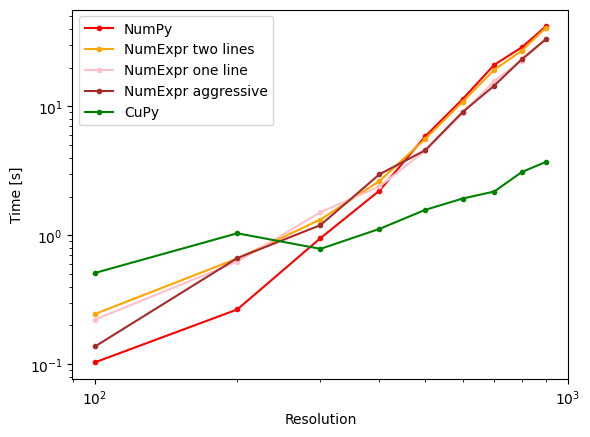

In [4]:
def get_points_xy(resolutions, results):
    points = []

    for i in range(len(resolutions)):
        points.append([resolutions[i], results[i]])


    data = np.array([points])
    x, y = data.T

    return [x, y]

x, y = get_points_xy(resolutions, results_default)
plt.loglog(x, y, color="red", marker='.', label="python")

x_c, y_c = get_points_xy(resolutions, results_numexpr)
plt.loglog(x_c, y_c, color="orange", marker='.', label="numexpr")

x_c, y_c = get_points_xy(resolutions, results_numexpr2)
plt.loglog(x_c, y_c, color="pink", marker='.', label="numexpr 2")

x_c, y_c = get_points_xy(resolutions, results_numexpr3)
plt.loglog(x_c, y_c, color="brown", marker='.', label="numexpr 3")

x_c, y_c = get_points_xy(resolutions, results_cupy)
plt.loglog(x_c, y_c, color="green", marker='.', label="CuPy")

print(results_default[-1]/results_numexpr[-1])
print(results_default[-1]/results_numexpr2[-1])
print(results_default[-1]/results_numexpr3[-1])

plt.xlabel('Resolution')
plt.ylabel('Time [s]')
plt.legend(['NumPy','NumExpr two lines', 'NumExpr one line', 'NumExpr aggressive', 'CuPy'])
plt.show()

In [ ]:
!